# Customer Clustering and Profile Analysis
## Behavioral Segmentation for NTL Detection

**Document Type:** Technical Analysis Report  
**Audience:** Data Scientists, Utility Analysts, Operations Teams  
**Prerequisites:** Review 01_EDA_and_Preprocessing.ipynb; artifacts must be generated  

---

### Rationale

A single anomaly detection model applied uniformly across all customers produces suboptimal results due to customer heterogeneity. This notebook establishes behavioral clusters to enable:

1. **Baseline calibration:** Define "normal" relative to peer group, not global population
2. **Threshold customization:** Set cluster-specific detection thresholds
3. **Interpretability:** Explain flags in context of customer segment
4. **Operational routing:** Route alerts to appropriate investigation teams

### Outputs

- `artifacts/cluster_model.joblib` - Trained clustering model
- `artifacts/cluster_profiles.json` - Cluster characteristics and descriptions

In [1]:
import sys
import json
from pathlib import Path
from datetime import datetime
import warnings

import numpy as np
import pandas as pd
from scipy import stats
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

PROJECT_ROOT = Path.cwd().parent
ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'

print(f'Project Root: {PROJECT_ROOT}')
print(f'Execution Time: {datetime.now().isoformat()}')

Project Root: c:\Users\MadScie254\Documents\GitHub\Capstone-Einstein\Capstone-Einstein
Execution Time: 2025-12-16T02:44:06.947424


## 1. Load Preprocessed Data

In [2]:
# Load features
features = pd.read_parquet(ARTIFACTS_DIR / 'preprocessed.parquet')

print('=== DATA LOADED ===')
print(f'Records: {len(features):,}')
print(f'Features: {len(features.columns)}')

# Filter to high-quality records only for clustering
if 'quality_flag' in features.columns:
    high_quality = features[features['quality_flag'] == 'HIGH'].copy()
    print(f'High-quality records for clustering: {len(high_quality):,}')
else:
    high_quality = features.copy()

=== DATA LOADED ===
Records: 25,863
Features: 47
High-quality records for clustering: 22,142


## 2. Feature Selection for Clustering

Clustering features should capture consumption behavior, not anomaly indicators. We exclude:
- Anomaly-specific features (zero_ratio, sudden_drop_count)
- Metadata (CONS_NO, FLAG, quality_flag)

This ensures clusters represent natural customer segments, not theft/non-theft groupings.

In [3]:
# Select clustering features
exclude_features = [
    'CONS_NO', 'FLAG', 'quality_flag',
    'zero_ratio', 'sudden_drop_count', 'sudden_drop_pct',
    'max_consecutive_zeros', 'missing_ratio', 'is_constant',
    'outlier_ratio', 'low_consumption_ratio'
]

cluster_features = [
    'consumption_mean', 'consumption_std', 'consumption_cv',
    'consumption_median', 'consumption_range',
    'autocorrelation', 'consumption_trend',
    'rolling_7d_mean_avg', 'weekly_pattern_strength'
]

# Filter to available features
cluster_features = [f for f in cluster_features if f in high_quality.columns]

print('=== CLUSTERING FEATURES ===')
for f in cluster_features:
    print(f'  - {f}')

X_cluster = high_quality[cluster_features].values
print(f'\nFeature matrix shape: {X_cluster.shape}')

=== CLUSTERING FEATURES ===
  - consumption_mean
  - consumption_std
  - consumption_cv
  - consumption_median
  - consumption_range
  - autocorrelation
  - consumption_trend
  - rolling_7d_mean_avg
  - weekly_pattern_strength

Feature matrix shape: (22142, 9)


In [4]:
# Handle missing values and scale
X_cluster = np.nan_to_num(X_cluster, nan=0.0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print('Features scaled to zero mean, unit variance')

Features scaled to zero mean, unit variance


## 3. Optimal Cluster Selection

We evaluate cluster counts using:
- **Silhouette Score:** Measures cohesion vs. separation
- **Calinski-Harabasz Index:** Ratio of between-cluster to within-cluster variance
- **Business interpretability:** Clusters must map to actionable segments

In [5]:
# Evaluate cluster counts
k_range = range(2, 8)
silhouette_scores = []
ch_scores = []
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))
    inertias.append(kmeans.inertia_)

# Display results
print('=== CLUSTER EVALUATION ===')
print(f'{"k":>3} {"Silhouette":>12} {"Calinski-H":>12} {"Inertia":>12}')
print('-' * 42)
for k, sil, ch, iner in zip(k_range, silhouette_scores, ch_scores, inertias):
    print(f'{k:3d} {sil:12.4f} {ch:12.1f} {iner:12.1f}')

=== CLUSTER EVALUATION ===
  k   Silhouette   Calinski-H      Inertia
------------------------------------------
  2       0.9926      20846.4     102637.4
  3       0.4539      14561.0      86065.9
  4       0.2413      14434.8      67412.5
  5       0.2925      15712.1      51908.0
  6       0.3075      16601.4      41954.8
  7       0.3093      16415.5      36567.5


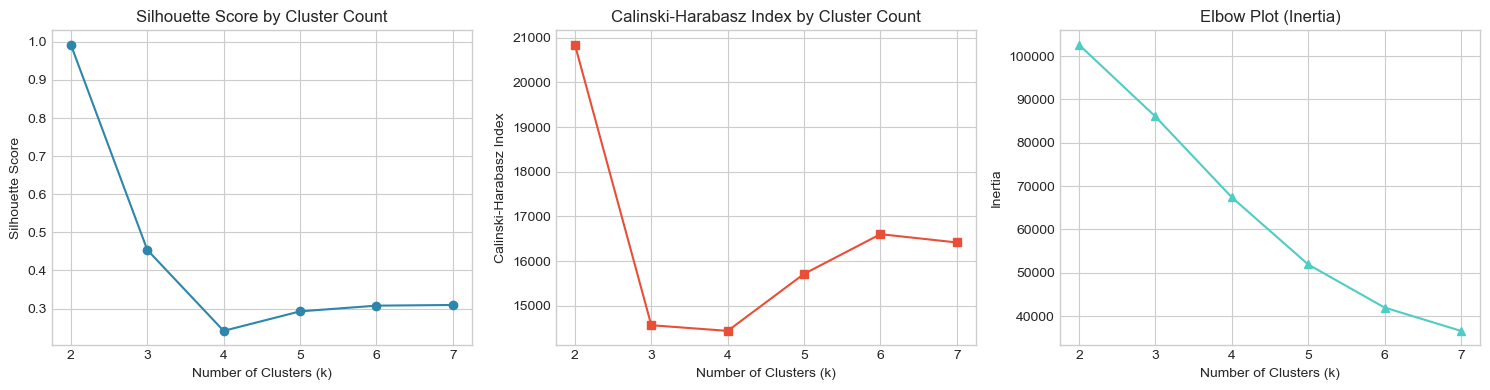

Figure saved: cluster_evaluation.png


In [6]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(list(k_range), silhouette_scores, 'o-', color='#2E86AB')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score by Cluster Count')

axes[1].plot(list(k_range), ch_scores, 's-', color='#E94F37')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Calinski-Harabasz Index')
axes[1].set_title('Calinski-Harabasz Index by Cluster Count')

axes[2].plot(list(k_range), inertias, '^-', color='#4ECDC4')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Inertia')
axes[2].set_title('Elbow Plot (Inertia)')

plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'cluster_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print('Figure saved: cluster_evaluation.png')

In [7]:
# Select optimal k (typically 3-5 for utility customers)
OPTIMAL_K = 4  # Based on silhouette and interpretability

print(f'\nSelected cluster count: k = {OPTIMAL_K}')
print('Rationale: Balances statistical metrics with operational interpretability')


Selected cluster count: k = 4
Rationale: Balances statistical metrics with operational interpretability


## 4. Train Final Clustering Model

In [8]:
# Train final model
cluster_model = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
high_quality['cluster'] = cluster_model.fit_predict(X_scaled)

# Assign clusters to all records
features['cluster'] = -1  # Default for low-quality records
features.loc[high_quality.index, 'cluster'] = high_quality['cluster']

print('=== CLUSTER DISTRIBUTION ===')
print(features['cluster'].value_counts().sort_index())

=== CLUSTER DISTRIBUTION ===
cluster
-1     3721
 0    10200
 1        1
 2    11935
 3        6
Name: count, dtype: int64


## 5. Cluster Profile Analysis

In [9]:
# Calculate cluster profiles
profile_features = ['consumption_mean', 'consumption_std', 'consumption_cv']
if 'zero_ratio' in features.columns:
    profile_features.append('zero_ratio')

cluster_profiles = high_quality.groupby('cluster')[profile_features].agg(['mean', 'std'])

print('=== CLUSTER PROFILES ===')
for cluster_id in range(OPTIMAL_K):
    cluster_data = high_quality[high_quality['cluster'] == cluster_id]
    print(f'\nCluster {cluster_id} (n = {len(cluster_data):,}):')
    print(f'  Mean consumption: {cluster_data["consumption_mean"].mean():.1f} kWh')
    print(f'  Consumption variability (CV): {cluster_data["consumption_cv"].mean():.2f}')
    if 'FLAG' in cluster_data.columns:
        print(f'  Theft rate: {cluster_data["FLAG"].mean():.2%}')

=== CLUSTER PROFILES ===

Cluster 0 (n = 10,200):
  Mean consumption: 8.8 kWh
  Consumption variability (CV): 0.48
  Theft rate: 7.13%

Cluster 1 (n = 1):
  Mean consumption: 19807.7 kWh
  Consumption variability (CV): 5.00
  Theft rate: 100.00%

Cluster 2 (n = 11,935):
  Mean consumption: 7.0 kWh
  Consumption variability (CV): 0.98
  Theft rate: 9.69%

Cluster 3 (n = 6):
  Mean consumption: 2056.6 kWh
  Consumption variability (CV): 1.04
  Theft rate: 83.33%


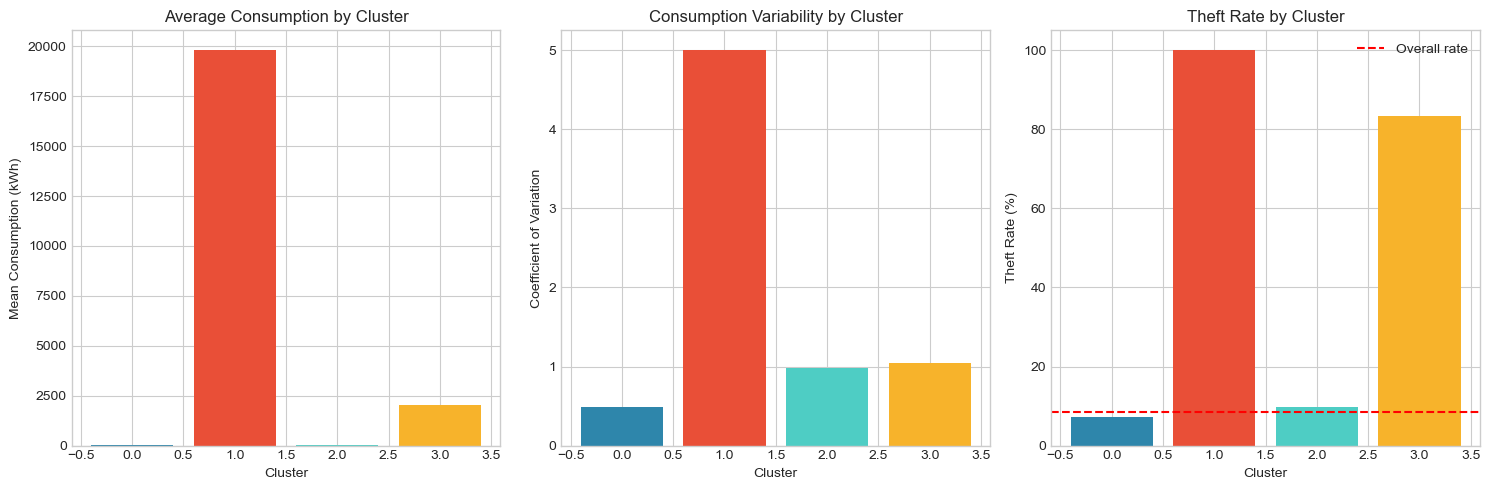

Figure saved: cluster_profiles.png


In [10]:
# Visualize cluster characteristics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Consumption by cluster
cluster_means = high_quality.groupby('cluster')['consumption_mean'].mean()
axes[0].bar(cluster_means.index, cluster_means.values, color=['#2E86AB', '#E94F37', '#4ECDC4', '#F7B32B'][:OPTIMAL_K])
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Mean Consumption (kWh)')
axes[0].set_title('Average Consumption by Cluster')

# Variability by cluster
cluster_cv = high_quality.groupby('cluster')['consumption_cv'].mean()
axes[1].bar(cluster_cv.index, cluster_cv.values, color=['#2E86AB', '#E94F37', '#4ECDC4', '#F7B32B'][:OPTIMAL_K])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Coefficient of Variation')
axes[1].set_title('Consumption Variability by Cluster')

# Theft rate by cluster (if labels available)
if 'FLAG' in high_quality.columns:
    cluster_theft = high_quality.groupby('cluster')['FLAG'].mean()
    axes[2].bar(cluster_theft.index, cluster_theft.values * 100, color=['#2E86AB', '#E94F37', '#4ECDC4', '#F7B32B'][:OPTIMAL_K])
    axes[2].set_xlabel('Cluster')
    axes[2].set_ylabel('Theft Rate (%)')
    axes[2].set_title('Theft Rate by Cluster')
    axes[2].axhline(high_quality['FLAG'].mean() * 100, color='red', linestyle='--', label='Overall rate')
    axes[2].legend()

plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'cluster_profiles.png', dpi=150, bbox_inches='tight')
plt.show()

print('Figure saved: cluster_profiles.png')

## 6. Business Interpretation

Assign meaningful labels to each cluster based on consumption characteristics.

In [11]:
# Generate cluster descriptions
cluster_descriptions = {}

for cluster_id in range(OPTIMAL_K):
    cluster_data = high_quality[high_quality['cluster'] == cluster_id]
    mean_consumption = cluster_data['consumption_mean'].mean()
    cv = cluster_data['consumption_cv'].mean()
    
    # Classify based on consumption level and variability
    if mean_consumption < 50:
        level = 'Low'
    elif mean_consumption < 150:
        level = 'Medium'
    else:
        level = 'High'
    
    if cv < 0.2:
        variability = 'Stable'
    elif cv < 0.5:
        variability = 'Moderate'
    else:
        variability = 'Variable'
    
    cluster_descriptions[cluster_id] = {
        'name': f'{level} Consumption, {variability} Pattern',
        'mean_consumption': float(mean_consumption),
        'cv': float(cv),
        'n_customers': len(cluster_data),
        'theft_rate': float(cluster_data['FLAG'].mean()) if 'FLAG' in cluster_data.columns else None
    }

print('=== CLUSTER INTERPRETATION ===')
for cluster_id, desc in cluster_descriptions.items():
    print(f'\nCluster {cluster_id}: {desc["name"]}')
    print(f'  Customers: {desc["n_customers"]:,}')
    print(f'  Avg consumption: {desc["mean_consumption"]:.1f} kWh')
    if desc['theft_rate'] is not None:
        print(f'  Theft rate: {desc["theft_rate"]:.2%}')

=== CLUSTER INTERPRETATION ===

Cluster 0: Low Consumption, Moderate Pattern
  Customers: 10,200
  Avg consumption: 8.8 kWh
  Theft rate: 7.13%

Cluster 1: High Consumption, Variable Pattern
  Customers: 1
  Avg consumption: 19807.7 kWh
  Theft rate: 100.00%

Cluster 2: Low Consumption, Variable Pattern
  Customers: 11,935
  Avg consumption: 7.0 kWh
  Theft rate: 9.69%

Cluster 3: High Consumption, Variable Pattern
  Customers: 6
  Avg consumption: 2056.6 kWh
  Theft rate: 83.33%


## 7. Save Artifacts

In [12]:
# Save cluster model
joblib.dump({
    'model': cluster_model,
    'scaler': scaler,
    'features': cluster_features,
    'n_clusters': OPTIMAL_K
}, ARTIFACTS_DIR / 'cluster_model.joblib')
print(f'Saved: {ARTIFACTS_DIR / "cluster_model.joblib"}')

# Save cluster profiles
cluster_profiles_output = {
    'n_clusters': OPTIMAL_K,
    'created_at': datetime.now().isoformat(),
    'profiles': cluster_descriptions
}

with open(ARTIFACTS_DIR / 'cluster_profiles.json', 'w') as f:
    json.dump(cluster_profiles_output, f, indent=2)
print(f'Saved: {ARTIFACTS_DIR / "cluster_profiles.json"}')

# Update preprocessed data with cluster assignments
features.to_parquet(ARTIFACTS_DIR / 'preprocessed.parquet', index=False)
print(f'Updated: {ARTIFACTS_DIR / "preprocessed.parquet"}')

Saved: c:\Users\MadScie254\Documents\GitHub\Capstone-Einstein\Capstone-Einstein\artifacts\cluster_model.joblib
Saved: c:\Users\MadScie254\Documents\GitHub\Capstone-Einstein\Capstone-Einstein\artifacts\cluster_profiles.json
Updated: c:\Users\MadScie254\Documents\GitHub\Capstone-Einstein\Capstone-Einstein\artifacts\preprocessed.parquet


## 8. Risks of Mis-clustering

### Potential Issues

1. **Cluster drift over time:** Seasonal changes may shift customers between clusters. Recommend quarterly cluster reassignment.

2. **Boundary customers:** Customers near cluster boundaries may be assigned differently on re-clustering. Consider soft clustering (GMM) for high-stakes decisions.

3. **New customer types:** Market changes (e.g., EV adoption, solar panels) may create customers that fit no existing cluster.

4. **Theft-induced cluster shifts:** Customers engaged in theft may appear as a different consumption profile. This is a feature, not a bug, but requires careful threshold calibration.

---

**Next Step:** Proceed to 03_Anomaly_and_Theft_Models.ipynb